## Лабораторная работа 1: Алгоритмы разложения матриц. PCA.
_Команда 13_ <br>
_Кондратов, Малышева, Оплетина, Штрейх_
### 1. Метод главных компонент
##### Cингулярное матричные разложения

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.linalg import svdvals
np.random.seed(48)

In [205]:
def norm(x: np.array) -> np.ndarray:
    '''
    Норма вектора

    Args:

        x - вектор

    Returns:

        Норма вектора
    '''
    return np.sqrt(x.dot(x.T))


def gram_schmidt(X:  np.ndarray):
    '''
    Алгоритм Грамма-Шмидта для получения QR разложения

    Args:

        X - матрица для которой нужно получить QR разложение

    Returns:

        Q - унитарная матрица

        R - верхнея треугольная матрица

    '''

    X = np.copy(X)
    v = np.zeros(X.shape)
    Q = np.zeros(X.shape)
    R = np.zeros((X.shape[1], X.shape[1]))

    for i in range(X.shape[1]):

        v[:, i] = X[:, i]

    for i in range(X.shape[1]):

        R[i, i] = norm(v[:, i])
        Q[:, i] = v[:, i]/R[i, i]

        for j in range(i+1, X.shape[1]):

            R[i, j] = Q[:, i].dot(v[:, j])
            v[:, j] -= R[i, j]*Q[:, i]
    return Q, R


def Hessenberg_form(X: np.ndarray) -> np.ndarray:
    '''
    Функция для приведения квадратной матрицы к форме Хессенберга с помощью алгоритма Хаусхолдера

    Args:

        X - квадратная матрица общего вида

    Returns:

        Матрица Хессенберга
    '''
    X = np.copy(X)
    m = X.shape[1]
    V = []
    for k in range(m-2):
        A = X[(k+1):, k]
        e = np.zeros(A.shape[0])
        e[0] = 1
        V.append(np.sign(A[0])*norm(A)*e + A)
        V[k] = V[k]/norm(V[k])
        for j in range(k, m):
            X[k+1:, j] = X[k+1:, j] - (2 * V[k].dot(X[k+1:, j])) * V[k]
        for j in range(k, m):
            X[j, k+1:] = X[j, k+1:] - 2 * (X[j, k+1:m].dot(V[k])) * V[k].T

    return X


def inverse_iteration(X: np.ndarray, mu: np.ndarray, it=10) -> np.ndarray:
    '''
    Функция для получения собственных векторов по имеющимся собственным значениям. 
    Реализуется при помощи алгоритма Inverse Iteration 

    Args:

        X - квадратная матрица

        mu - список собственных значений

        it - максимальное количество итераций алгоритма

    Returns:

        Матрица из собственных векторов матрицы X

    '''
    A = np.copy(X)
    m = A.shape[0]
    v = np.random.randn(m)
    v = v/norm(v)
    eigen_vec = np.zeros((m, m))
    eigen_val = []
    for stolb, l in enumerate(mu):
        for i in range(it):
            w = np.linalg.solve(A-l*np.eye(m), v)
            v = w / norm(w)
            if abs(v.T.dot(A).dot(v) - l) < 1e-5:
                break
        eigen_vec[:, stolb] = v
        eigen_val.append(l)
    return eigen_vec


def QR(X: np.ndarray, n=1000) -> np.ndarray:
    '''
    Функция для нахождения собственных значений при помощи QR разложения

    Args:

        X - квадратная матрица для которой нужно получить собственные числа

        n - количество итераций QR алгоритма

    Returns:

        Отсортированный по убыванию список собственных значений
    '''
    A = np.copy(X)
    A = Hessenberg_form(A)
    for i in range(n):
        Q, R = gram_schmidt(A)
        A = R.dot(Q)
    return sorted(np.diag(A), reverse=True)


def QR_with_shifts(X: np.ndarray, n=5) -> np.ndarray:
    '''
    Функция для нахождения собственных значений при помощи QR разложения со сдвигом

    Args:

        X - квадратная матрица для которой нужно получить собственные числа

        n - количество итераций QR алгоритма

    Returns:

        Отсортированный по убыванию список собственных значений
'''
    if len(X) == 1:
        return X[0]
    A = np.copy(X)
    A = Hessenberg_form(A)
    m = A.shape[0]
    vals = []
    while abs(A[m-1, m-2]) > 1e-2:
        mu = A[m-1, m-1]
        Q, R = gram_schmidt(A - mu*np.eye(m))
        A_new = R.dot(Q)+mu*np.eye(m)
        A = A_new
        for k in range(A.shape[0]-1):
            if np.abs(A_new[k, k+1]) < 1e-4:
                A_new[k, k+1] = A_new[k+1, k] = 1e-2

    vals = sorted(np.append(QR_with_shifts(
        A[:m-1, :m-1]), QR_with_shifts([A[m-1:, m-1:]])), reverse=True)
    return vals


def svd(X: np.ndarray, shifts=False, only_vals=False, fast=False):
    '''
    Функция для получения сингулярного разложения матрицы объект-признак

    Args:
        X - матрица объект-признак 

        shifts - если True, то используется QR алгоритм со сдвигами 

        only_vals - если True, то функция возвращает только сингулярные числа

    returns:
        U - левые сингулярные векторы 

        sigma - сингулярные числа 

        V - правые сингулярные векторы
    '''

    X = np.copy(X)
    # Центрирование
    if not fast:
        X = X - X.mean(axis=0)

    if shifts:
        # получение собственных значений
        sigma = QR_with_shifts(X.T.dot(X))
        if not only_vals:
            # получение матриц из собственных векторов
            V = inverse_iteration(X.T.dot(X), sigma)
            U = inverse_iteration(X.dot(X.T), np.append(
                sigma, [0]*abs(X.shape[0] - X.shape[1])))
            # сингулярные числа
            sigma = np.sqrt(sigma)
            return U, sigma,  V
        else:
            sigma = np.sqrt(sigma)
            return sigma
    else:
        # получение собственных значений
        sigma = QR(X.T.dot(X))
        if not only_vals:
            # получение матриц из собственных векторов
            V = inverse_iteration(X.T.dot(X), sigma)
            U = inverse_iteration(X.dot(X.T), np.append(
                sigma, [0]*abs(X.shape[0] - X.shape[1])))
            # сингулярные числа
            sigma = np.sqrt(sigma)
            return U, sigma,  V
        else:
            sigma = np.sqrt(sigma)
            return sigma

In [206]:
def test_svd(n: int, rows: int, cols: int, shifts=True):
    '''
    Функция для проверки правильности сингулярного разложения. 
    За правильный ответ берется реализация сингулярного разложения из библиотеки scipy.
    Сравниваются собственные значения. В конце выводится количество ошибок.
    Матрица объект - признак генерируется случайно для каждой итерации.

    Args:

        n - количество итераций проверки

        rows - количество строк в матрице объект - признак

        cols - количство столбцов в матрице объект - признак

        shifts - если True, то применяется QR алгоритм со сдвигом

    Returns:

        None
    '''

    wrong_answ = 0
    for i in tqdm(range(n)):
        X = np.random.rand(rows, cols)
        sigma_pred = svd(X, shifts=shifts, only_vals=True)
        X = X - X.mean(axis=0)
        sigma_true = svdvals(X)
        if np.all(np.abs(sigma_true - sigma_pred) > 1e-3):
            wrong_answ += 1
    print('количество неверных ответов:', wrong_answ)

In [207]:
test_svd(1000, 100, 10, shifts=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

количество неверных ответов: 0


# Представление набора данных

In [96]:
# Импорт данных
# Это датасет с характеристиками игроков в FIFA 2022
# https://www.kaggle.com/datasets/bryanb/fifa-player-stats-database?select=FIFA22_official_data.csv

path = '/Users/pavelkondratov/Library/CloudStorage/OneDrive-экономическийфакультетМГУим.М.В.Ломоносова/ИТМО/МОМО/лаба 2/FIFA22_official_data.csv'
data = pd.read_csv(path)

In [6]:
# немного предобработки
# Возьмем легко интерпретируемые признаки
# Возраст, Общий рейтинг,
# Стоимость игрока на трансферном рынке, Зарплата игрока, Рост игрогка, Вес игрока, Скорость бега
# Выносливость, сила, позиция игрока
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16710 entries, 0 to 16709
Data columns (total 65 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        16710 non-null  int64  
 1   Name                      16710 non-null  object 
 2   Age                       16710 non-null  int64  
 3   Photo                     16710 non-null  object 
 4   Nationality               16710 non-null  object 
 5   Flag                      16710 non-null  object 
 6   Overall                   16710 non-null  int64  
 7   Potential                 16710 non-null  int64  
 8   Club                      16446 non-null  object 
 9   Club Logo                 16710 non-null  object 
 10  Value                     16710 non-null  object 
 11  Wage                      16710 non-null  object 
 12  Special                   16710 non-null  int64  
 13  Preferred Foot            16710 non-null  object 
 14  Intern

In [7]:
cols_to_select = ['Overall', 'Best Position', 'Age', 'Value',
                  'Wage', 'Height', 'Weight', 'SprintSpeed', 'Stamina', 'Strength']
data1 = data.loc[:, cols_to_select].dropna(how='any', axis=0)
data1.head()

,Overall,Best Position,Age,Value,Wage,Height,Weight,SprintSpeed,Stamina,Strength
0,88,CAM,26,€107.5M,€250K,179cm,69kg,73.0,91.0,70.0
1,87,CM,26,€93M,€140K,189cm,82kg,83.0,88.0,88.0
2,88,ST,34,€44.5M,€135K,182cm,83kg,69.0,78.0,85.0
3,91,CM,30,€125.5M,€350K,181cm,70kg,76.0,89.0,74.0
4,84,LB,29,€37M,€45K,172cm,69kg,76.0,90.0,80.0


In [8]:
# Приведем все к числовому виду
# Все стоимости игроков и их зарплаты указаны в евро
# Они имеют приписку либо "М" - миллионы, либо "К" - тысячи, либо не имеют приписки вообще
# Приведем их к значениям в миллионах
data1['Value'].apply(
    lambda x: x[-1]).unique(), data1['Wage'].apply(lambda x: x[-1]).unique()

(array(['M', '0', 'K'], dtype=object), array(['K', '0'], dtype=object))

In [9]:
def convert_money(row: str):
    '''
    Функция для приведения денежного формата к числовому в миллионах

    Args:

        row - строка с денежным форматом

    Returns:

        число в миллионах (float)
    '''
    if row[-1] == 'M':
        return float(row[1:len(row)-1])
    elif row[-1] == 'K':
        return float(row[1:len(row)-1])*1e-3
    else:
        return float(row[1:])*1e-6


data1['Value'] = data1['Value'].apply(convert_money)
data1['Wage'] = data1['Wage'].apply(convert_money)

In [10]:
# Рост указан в сантиметрах, а вес в килограммах
# можно просто отбросить cm и kg
data1['Height'] = data1['Height'].apply(lambda x: float(x[:-2]))
data1['Weight'] = data1['Weight'].apply(lambda x: float(x[:-2]))

In [11]:
# посмотрим на преобразованные данные
data1.dtypes

Overall            int64
Best Position     object
Age                int64
Value            float64
Wage             float64
Height           float64
Weight           float64
SprintSpeed      float64
Stamina          float64
Strength         float64
dtype: object

In [12]:
# Посмотрим на размер получившегося датасета
print('количество строк:', data1.shape[0],
      '\n', 'количесво столбцов:', data1.shape[1])

количество строк: 16710 
 количесво столбцов: 10


In [13]:
# получается достаточно большое количество данных
# возьмем только тех игроков, у которых рейтинг больше 80
data2 = data1[(data1['Value'] > 0) & (
    data1['Wage'] > 0) & (data1['Overall'] >= 60)]
data3 = data2.drop(['Best Position', 'Overall'], axis=1)
print('количество строк:', data3.shape[0],
      '\n', 'количесво столбцов:', data3.shape[1])

количество строк: 14790 
 количесво столбцов: 8


##### Применение метода сингулярного разложения на данных

In [15]:
def pca(X: np.ndarray, shifts=True):
    '''
    Функция для получения матрицы перехода и собственных значений. 
    По сути это копия функции SVD, где нет части с вычислением левых сингулярных векторов

    Args:

        X - матрица объект-признак

        shifts - если True, то используется QR алгоритм со сдвигами

    Returns:

        sigma - список собственных значений 

        V - матрица правых сингулярных векторов (Матрица перехода)


    '''
    X = np.copy(X)
    # Центрирование
    X = X - X.mean(axis=0)
    if shifts:
        # получение собственных значений
        sigma = QR_with_shifts(X.T.dot(X))
        # получение матриц из собственных векторов
        V = inverse_iteration(X.T.dot(X), sigma)
        # сингулярные числа
        sigma = np.sqrt(sigma)
        return sigma,  V
    else:
        # получение собственных значений
        sigma = QR(X.T.dot(X))
        # получение матриц из собственных векторов
        V = inverse_iteration(X.T.dot(X), sigma)
        # сингулярные числа
        sigma = np.sqrt(sigma)
        return sigma,  V

In [16]:
# Получаем сингулярное разложение
# Нас интересуют правые сингулярные вектора (матрица V)
sigma, V = pca(data3.to_numpy(), shifts=True)

Нас интересуют сингулярные числа - sigma, и матрица перехода, состоящая из правых сингулярных векторов - V

На основе вклада каждой компоненты в описание дисперсии данных мы определяем размерность нового пространства - $n_1$ <= V.shape[1]

А чтобы перейти к новому базису необходимо отбросить все столбцы начиная с $n_1$ в матрице V (получим матрицу $V_{new}$)

Затем домножив наши исходные данные на матрицу $V_{new}$ справа мы получим представление наших данных в новом подпространстве меньшей размерности

##### Определение числа компонент, визуализация данных, анализ полученных компонент

Text(0.5, 1.0, 'График накопленного вклада компонент в описание дисперсии данных')

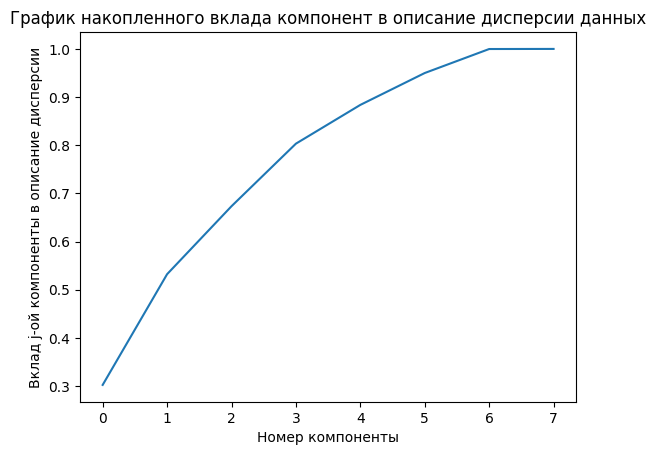

In [17]:
# Найдем вклад каждой компоненты
plt.plot(range(len(sigma)), np.cumsum(sigma / np.sum(sigma)))
plt.xlabel('Номер компоненты')
plt.ylabel('Вклад j-ой компоненты в описание дисперсии')
plt.title('График накопленного вклада компонент в описание дисперсии данных')

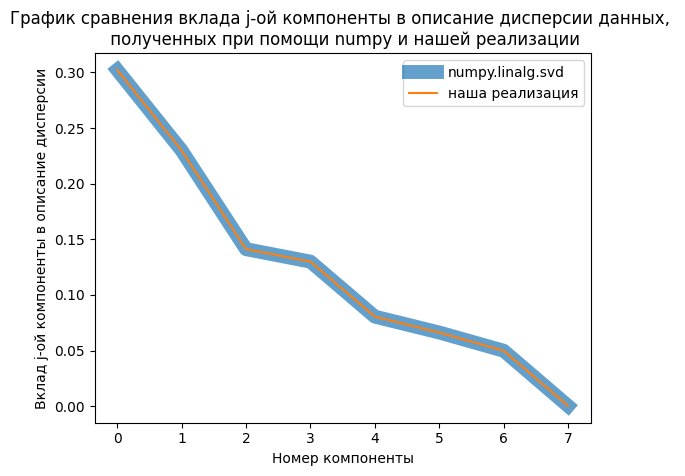

In [18]:
# Сравним полученное разложение с реализацией из библиотеки numpy
# нормируем данные
X = data3.to_numpy()
X = X - X.mean(axis=0)
# Найдем вклад каждой компоненты
U_2, sigma_2, V_2 = np.linalg.svd(X)
# Найдем вклад каждой компоненты
plt.plot(range(len(sigma_2)), sigma_2 / np.sum(sigma_2),
         label='numpy.linalg.svd', alpha=0.7, lw=10)
plt.plot(range(len(sigma)), sigma / np.sum(sigma), label='наша реализация')
plt.xlabel('Номер компоненты')
plt.ylabel('Вклад j-ой компоненты в описание дисперсии')
plt.title('График сравнения вклада j-ой компоненты в описание дисперсии данных, \n полученных при помощи numpy и нашей реализации')
plt.legend()

In [19]:
# Допустим мы хотим сохранить 80% дисперсии, тогда нам необходимо использовать первые 4 компоненты
n_new = np.array([np.where(np.cumsum(sigma / np.sum(sigma)) >= 0.8)]).min()+1
n_new

4

In [20]:
# Чтобы перейти к новому пространсту необходимо выкинуть все столбцы в матрице V из сингулярного разложения начиная с 16
V_new = V[:, :n_new]
# Тепрь надо перемножить матрицу V_new и data3
# Так мы получем представление исходных данных в новом базисе
data_new = data3.to_numpy()
data_new = data_new - data_new.mean(axis=0)
data_new = data_new.dot(V_new)
data_new = pd.DataFrame(data_new)
data_new.head()

,0,1,2,3
0,-33.249561,18.741810,-17.198651,-98.642053
1,-30.755285,35.612181,-30.757789,-78.206075
2,-10.878504,25.837034,-11.196218,-35.650733
3,-34.548424,23.658595,-26.474011,-114.152057
4,-28.261305,17.336618,-1.267059,-29.416650


In [22]:
# посмотрим на компоненты
V_df = pd.DataFrame(V_new)
V_df['name'] = cols_to_select[2:]
V_df

,0,1,2,3,name
0,0.055485,0.097767,0.093559,-0.012594,Age
1,-0.096297,0.097645,-0.274072,-0.950791,Value
2,-0.000179,0.000281,-0.000537,-0.001956,Wage
3,0.194853,0.270281,-0.189601,0.034796,Height
4,0.193502,0.309532,-0.221171,0.049377,Weight
5,-0.671786,-0.152372,-0.669975,0.244364,SprintSpeed
6,-0.674912,0.399214,0.569090,-0.066093,Stamina
7,0.073723,0.793383,-0.241944,0.167640,Strength


Интерпретация новых признаков

0 (Вратари)

Вратари. Высокие, медленные с низкой выносливостью игроки. 

1 (Защитники)

В современном мире защитники высоко ценятся на трансферном рынке. Зачастую это рослые игроки, готовые навязать контактную игру.

2 (Футболисты box to box)

Футболисты, которые бегают от ворот до ворот. Поэтому их главная характеристика выносливость. Однако, в современном футболе они не сильно ценятся

3 (Фланговые защитники)

Их главная задача быстро бегать и иметь возможность отобрать мяч

Интерпретация новых признаков

0 (Обычные возрастные игроки (вратари))

Взрослые высокие игроки с низкой выносливость и низкой скоростью спринта. Можно предположить, что это будут вратари так как обладают низкой скоростью бега, при том достаточно высокие

1 (Обычный молодой игрок)

Молодой игрок с небольшой строимостью и неплохой скоростью бега. Обладает малым весом и низким ростом и из-за этого низким показателем силы

2 (Молодые игроки поколения)

Высоко ценятся на трасферном рынке. Скорее всего это может быть современный молодой нападающий (например Мбаппе)

3 (Топовый взрослый игрок)

Высоко ценятся на трасферном рынке. Обладают высокой заработной платой, но медленно бегают



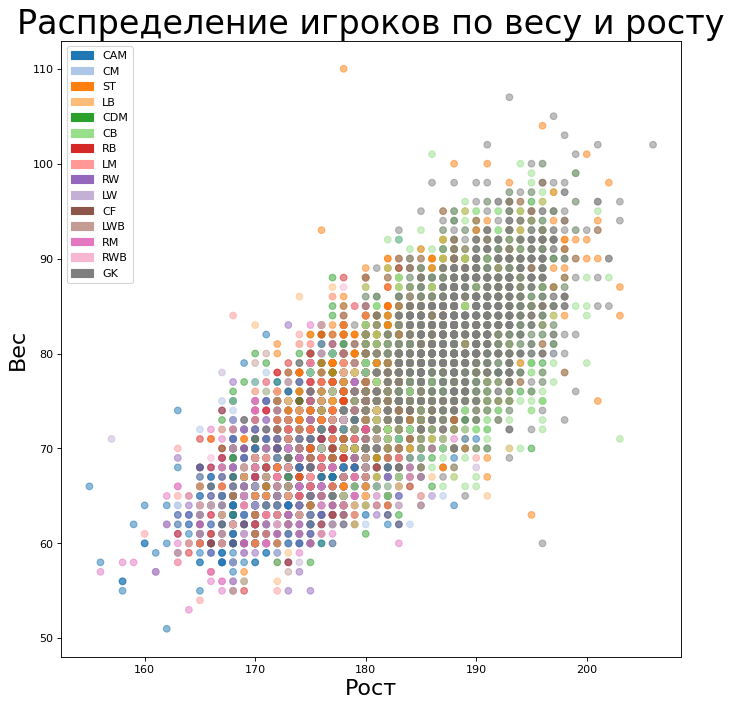

In [23]:
levels, categories = pd.factorize(data2['Best Position'])
colors = [plt.cm.tab20(i) for i in levels]  # using the "tab10" colormap
handles = [mpl.patches.Patch(color=plt.cm.tab20(i), label=c)
           for i, c in enumerate(categories)]

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(data3['Height'], data3['Weight'], c=colors, alpha=0.5)
plt.xlabel('Рост', size=20)
plt.ylabel('Вес', size=20)
plt.title('Распределение игроков по весу и росту', size=30)
plt.legend(handles=handles)

Чем выше человек, тем больше он будет весить. Справа наверху сконцентрировались голкиперы (GK), потому что зачастую это самые высокие игроки на футбольном поле

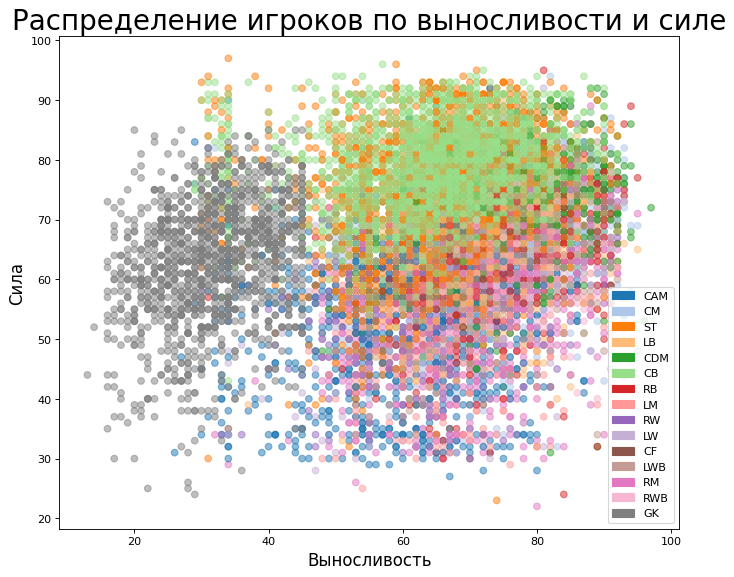

In [24]:
levels, categories = pd.factorize(data2['Best Position'])
colors = [plt.cm.tab20(i) for i in levels]  # using the "tab10" colormap
handles = [mpl.patches.Patch(color=plt.cm.tab20(i), label=c)
           for i, c in enumerate(categories)]

plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(data2['Stamina'], data2['Strength'], c=colors, alpha=0.5)
plt.xlabel('Выносливость', size=15)
plt.ylabel('Сила', size=15)
plt.title('Распределение игроков по выносливости и силе', size=25)
plt.legend(handles=handles)

Достаточно хорошо различимы два класса игроков - голкиперы и защитники (CB). Вратари обладают наименьшей выносливостью среди всех игроков, так как им не нужно бегать. Для защитников одним из ключевых показателей является сила. За счет нее они могут толкаться с игроками противоположной команды и отбирать мяч

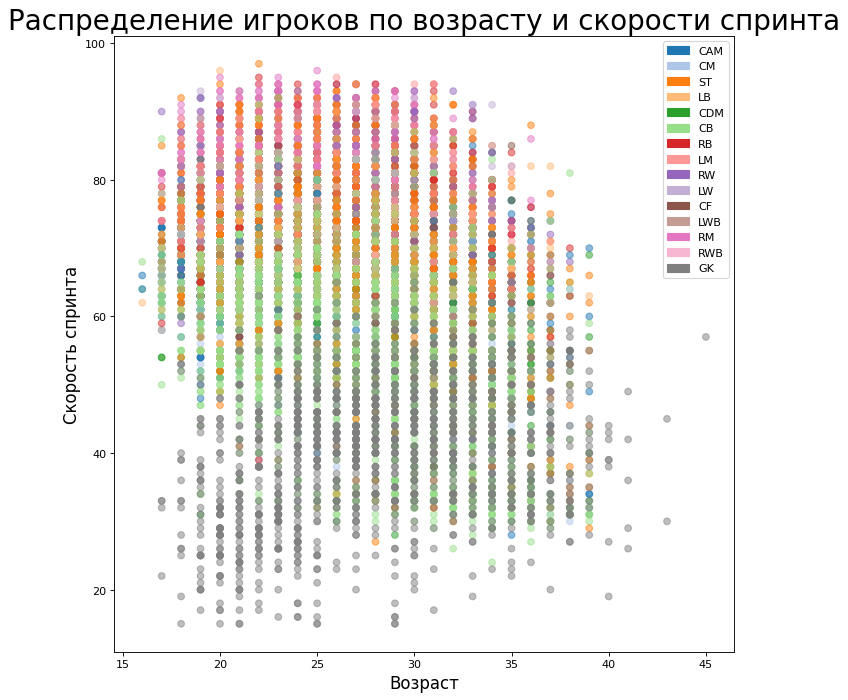

In [25]:
levels, categories = pd.factorize(data2['Best Position'])
colors = [plt.cm.tab20(i) for i in levels]  # using the "tab10" colormap
handles = [mpl.patches.Patch(color=plt.cm.tab20(i), label=c)
           for i, c in enumerate(categories)]

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(data2['Age'], data2['SprintSpeed'], c=colors, alpha=0.5)
plt.xlabel('Возраст', size=15)
plt.ylabel('Скорость спринта', size=15)
plt.title('Распределение игроков по возрасту и скорости спринта', size=25)
plt.legend(handles=handles)

На этом графике достаточно хорошо различимы все основные классы игроков. Самые медленные - вратари. Им вообще не надо бегать, поэтому и скорость рывка низкая. Затем идут центральные защитники. Для них скорость рывка является важными аспектом, но не ключевым. Самыми быстрыми являются игроки атакующей группы. Можно заметить, что с возрастом скорость спринта снижается. Особенно это заметно после 35 лет.

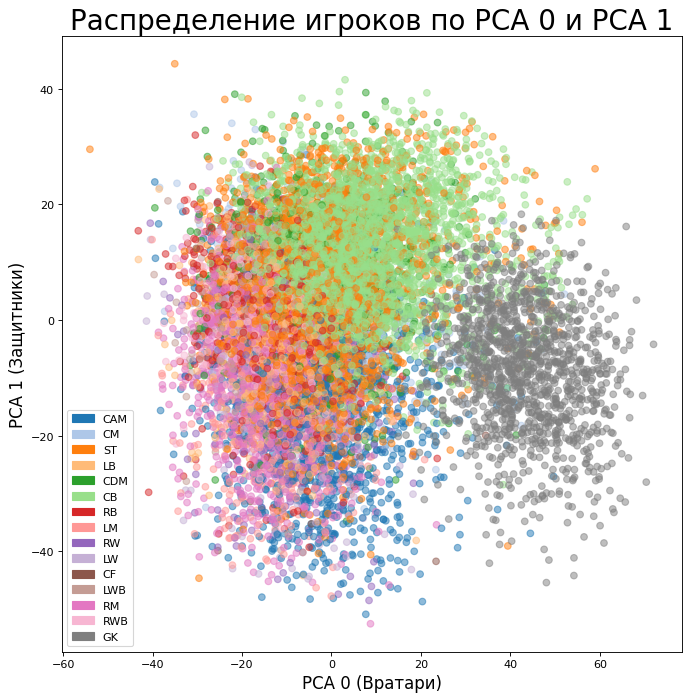

In [27]:
levels, categories = pd.factorize(data2['Best Position'])
colors = [plt.cm.tab20(i) for i in levels]  # using the "tab10" colormap
handles = [mpl.patches.Patch(color=plt.cm.tab20(i), label=c)
           for i, c in enumerate(categories)]

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(data_new[0], data_new[1], c=colors, alpha=0.5)
plt.xlabel('PCA 0 (Вратари)', size=15)
plt.ylabel('PCA 1 (Защитники)', size=15)
plt.title('Распределение игроков по PCA 0 и PCA 1', size=25)
plt.legend(handles=handles)

Этим новым признакам удалось дать качественную интерпретацию. На графики видно четкое разделение данных. Признак "Вратари" очень хорошо отранжировал игроков по позициям. Часто, когда удаляют вратаря с поля (это редкое событие, но оно случается), на ворота ставят высоких нападающих или защитников.

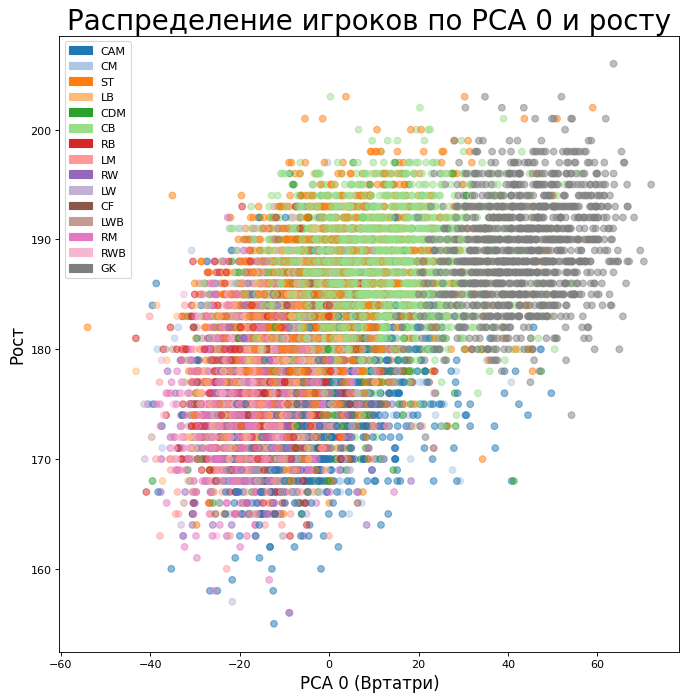

In [28]:
levels, categories = pd.factorize(data2['Best Position'])
colors = [plt.cm.tab20(i) for i in levels]  # using the "tab10" colormap
handles = [mpl.patches.Patch(color=plt.cm.tab20(i), label=c)
           for i, c in enumerate(categories)]

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(data_new[0], data3['Height'], c=colors, alpha=0.5)
plt.xlabel('PCA 0 (Вртатри)', size=15)
plt.ylabel('Рост', size=15)
plt.title('Распределение игроков по PCA 0 и росту', size=25)
plt.legend(handles=handles)

Данный график подтверждает предположение относительно роста. При этом график напоминает распределение роста и веса игроков.

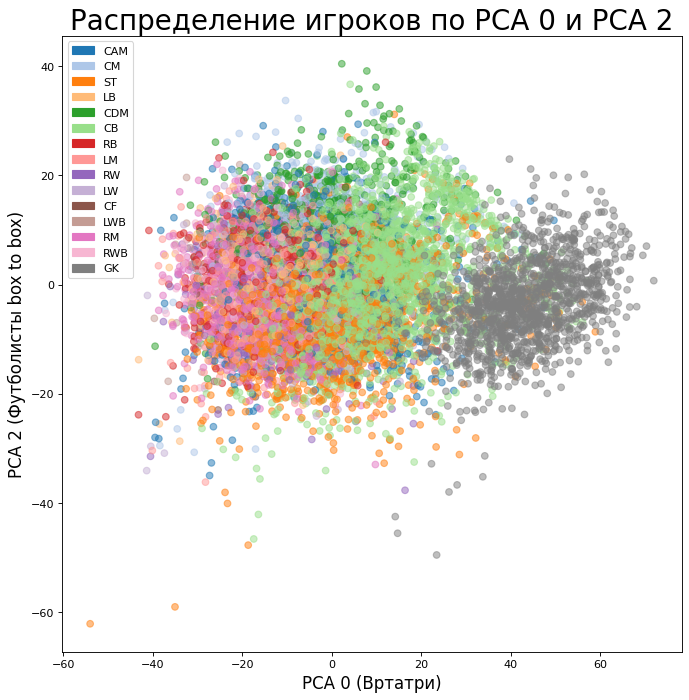

In [29]:
levels, categories = pd.factorize(data2['Best Position'])
colors = [plt.cm.tab20(i) for i in levels]  # using the "tab10" colormap
handles = [mpl.patches.Patch(color=plt.cm.tab20(i), label=c)
           for i, c in enumerate(categories)]

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(data_new[0], data_new[2], c=colors, alpha=0.5)
plt.xlabel('PCA 0 (Вртатри)', size=15)
plt.ylabel('PCA 2 (Футболисты box to box)', size=15)
plt.title('Распределение игроков по PCA 0 и PCA 2', size=25)
plt.legend(handles=handles)

В данном случае PCA 2 не так хорошо разделяет футболистов. По сути вратари неотличимы от нападющих. Это нехорошо

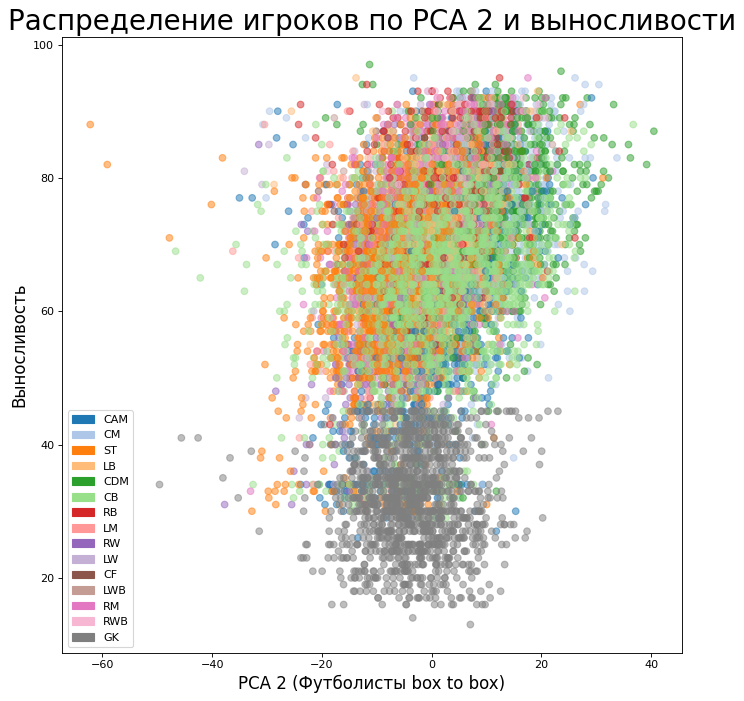

In [30]:
levels, categories = pd.factorize(data2['Best Position'])
colors = [plt.cm.tab20(i) for i in levels]  # using the "tab10" colormap
handles = [mpl.patches.Patch(color=plt.cm.tab20(i), label=c)
           for i, c in enumerate(categories)]

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(data_new[2], data3['Stamina'], c=colors, alpha=0.5)
plt.xlabel('PCA 2 (Футболисты box to box)', size=15)
plt.ylabel('Выносливость', size=15)
plt.title('Распределение игроков по PCA 2 и выносливости', size=25)
plt.legend(handles=handles)

К сожалению, начиная со второй компоненты, крайне сложно дать адекватную интерпретацию полученной компоненте. Разброс игроков получается не таким большим (доля объясненной дисперсии крайне мала), хотя по логике вратари должны в значительной степени отличаться от остальных игроков. При этом наибольший показатель "Футболисты box to box" должен быть у полузащитников (CM, CAM или CDM). 

##### Преимущества и недостатки применения сингулярного и спектрального разложения к задачам PCA

Преимущества:

1. Помогает избавится от коррелированных признаков

    В случае с сильно коррелированными данными возможна ситуация получения датасета меньшей размерности с полным сохранением дисперсии данных

2. Возможность визуализирования

    При помощи PCA можно можно получить представление данных в двумерном пространстве, которое легко поддается визуализации

3. Может помочь с переобучением

    За счет снижения размерности можно бороться с "проклятием размерности". Это может привести к повышению качества модели и повысить скорость обучения

Недостатки

1. Сложность интерпретации новых признаков

2. Потеря информации

    Снижение размерности (любым способом) зачастую ведет к потери информации. Поэтому всегда стоит сравнивать результаты модели обученной на данных PCA и обычных. Возможно, что алгоритм будет работать лучше на сырых данных

3. Для больших датасетов вычисление PCA будет крайне сложным

    Пусть m - количество признаков, n - количество наблюдений. Тогда сложность алгоритма O(n * m^2 + m^3). Чем больше признаков, тем дольше работает алгоритм

4. PCA - линейный метод

    Линейных преобразований может быть недостаточно для качественного снижения размерности. Поэтому существуют другие методы снижения размерности, например T-SNE

5. На PCA значительное влияние оказывают выбросы (следствие линейности метода)




# Дополнительное задание

Основная идея рандомизированного SVD: Перейти в случайное пространство меньшей размерности в котором дешевле вычисляется обычный SVD. Это позволяет существенно экономить вычислительные ресурсы. Авторы идеи: “Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions” by Halko, Martinsson, and Tropp (Halko et al., 2011). Случайность - это алгоритмический ресурс, создающий эффективные, несмещенные аппроксимации неслучайных операций.

In [503]:
def rand_svd(A: np.ndarray, k):

    over = A.shape[1] + k

    # Матрица рандомной проекции

    omega = np.random.random((A.shape[1], over))

    Y = A.dot(omega)

    Q, _ = np.linalg.qr(Y)

    # Находим проекцию на меньшее пространство

    B = Q.T.dot(A)

    # В нем применяем обычный svd

    U_1, sigma, V = svd(B, shifts=True, fast=True)

    # Получаем обратную проекцию

    U = Q.dot(U_1)

    return U, sigma, V

Сравнение скорости работы

In [505]:
import time

# Randomizer SVD
X = np.random.rand(1000, 50)
X = X - X.mean(axis=0)
start_time = time.time()
U, sigma, V = rand_svd(X, 5)
end_time = time.time()
print(end_time - start_time)

0.2849452495574951


In [506]:
# обычный SVD, который мы реализовали ранее
start_time = time.time()
U, sigma, V = svd(X, shifts=True)
end_time = time.time()
print(end_time - start_time)

24.271098852157593


In [507]:
# Реализация numpy
start_time = time.time()
U, sigma, V = np.linalg.svd(X)
end_time = time.time()
print(end_time - start_time)

0.04537081718444824


Сравнение собственных значений

In [508]:
X = np.random.rand(1000, 10)
X = X - X.mean(axis=0)
# наша реализация
U, sigma, V = rand_svd(X, 5)
# реализация numpy
U, sigma_1, V = np.linalg.svd(X)
sigma, sigma_1

(array([9.83861011, 9.69312748, 9.34146747, 9.31082251, 9.21966173,
        9.12235286, 8.89657375, 8.71434627, 8.60540443, 8.32809467]),
 array([9.83861011, 9.69312748, 9.34146747, 9.31082251, 9.21966173,
        9.12235286, 8.89657375, 8.71434627, 8.60540443, 8.32809466]))

### 2. Kernel PCA

##### Представление набора данных

##### Реализация методов вычисления матрицы для различных ядер  и её последующего спектрального разложения

##### Сравнительный анализ применения PCA и Kernel PCA